In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.optimize import curve_fit as cf
import numba
import scienceplots

In [3]:
plt.style.use(['science','ieee'])

In [4]:
N=20

In [5]:
init_random=np.random.random((N,N))
lattice_Po=np.ones((N,N))
lattice_Ne=np.ones((N,N))

In [6]:
lattice_Po[init_random>=0.75]=-1
lattice_Ne[init_random<=0.75]=-1


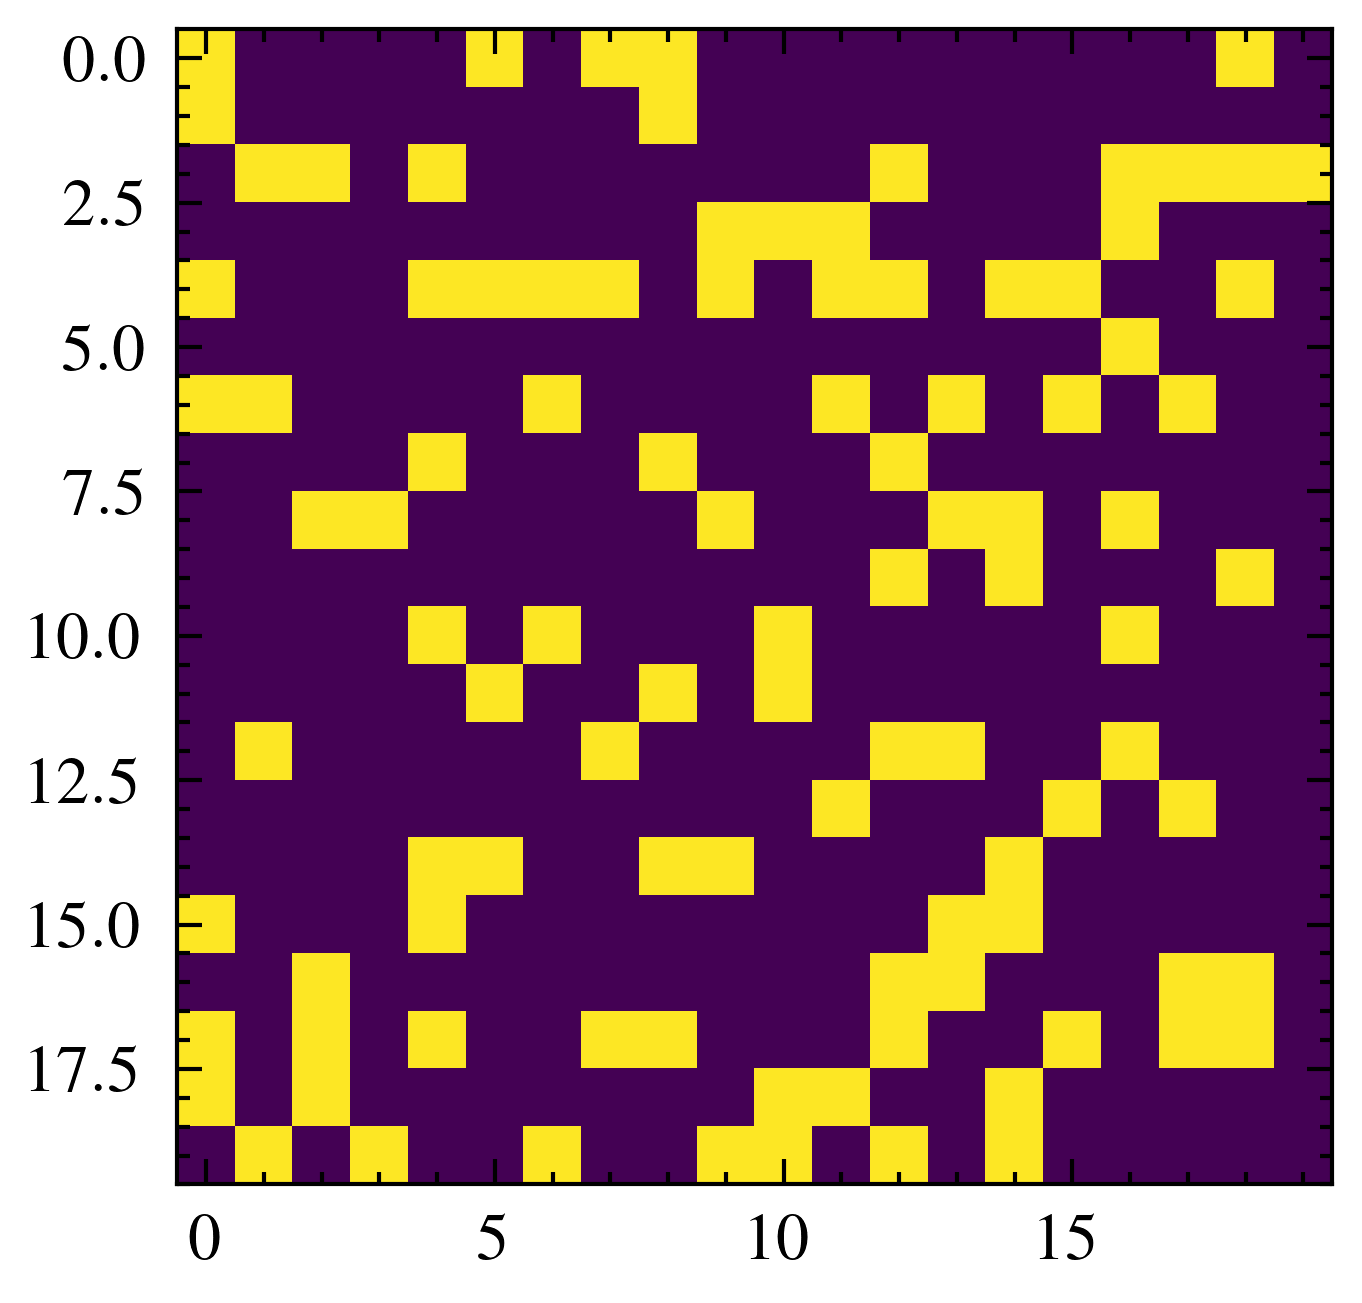

In [7]:
plt.imshow(lattice_Ne)

In [8]:
def get_lattice_energy(lattice):        
    kern = ndimage.generate_binary_structure(2, 1)
    kern[1][1]=False
    arr= -lattice*ndimage.convolve(lattice,kern,mode='wrap')
    return arr.sum()/2

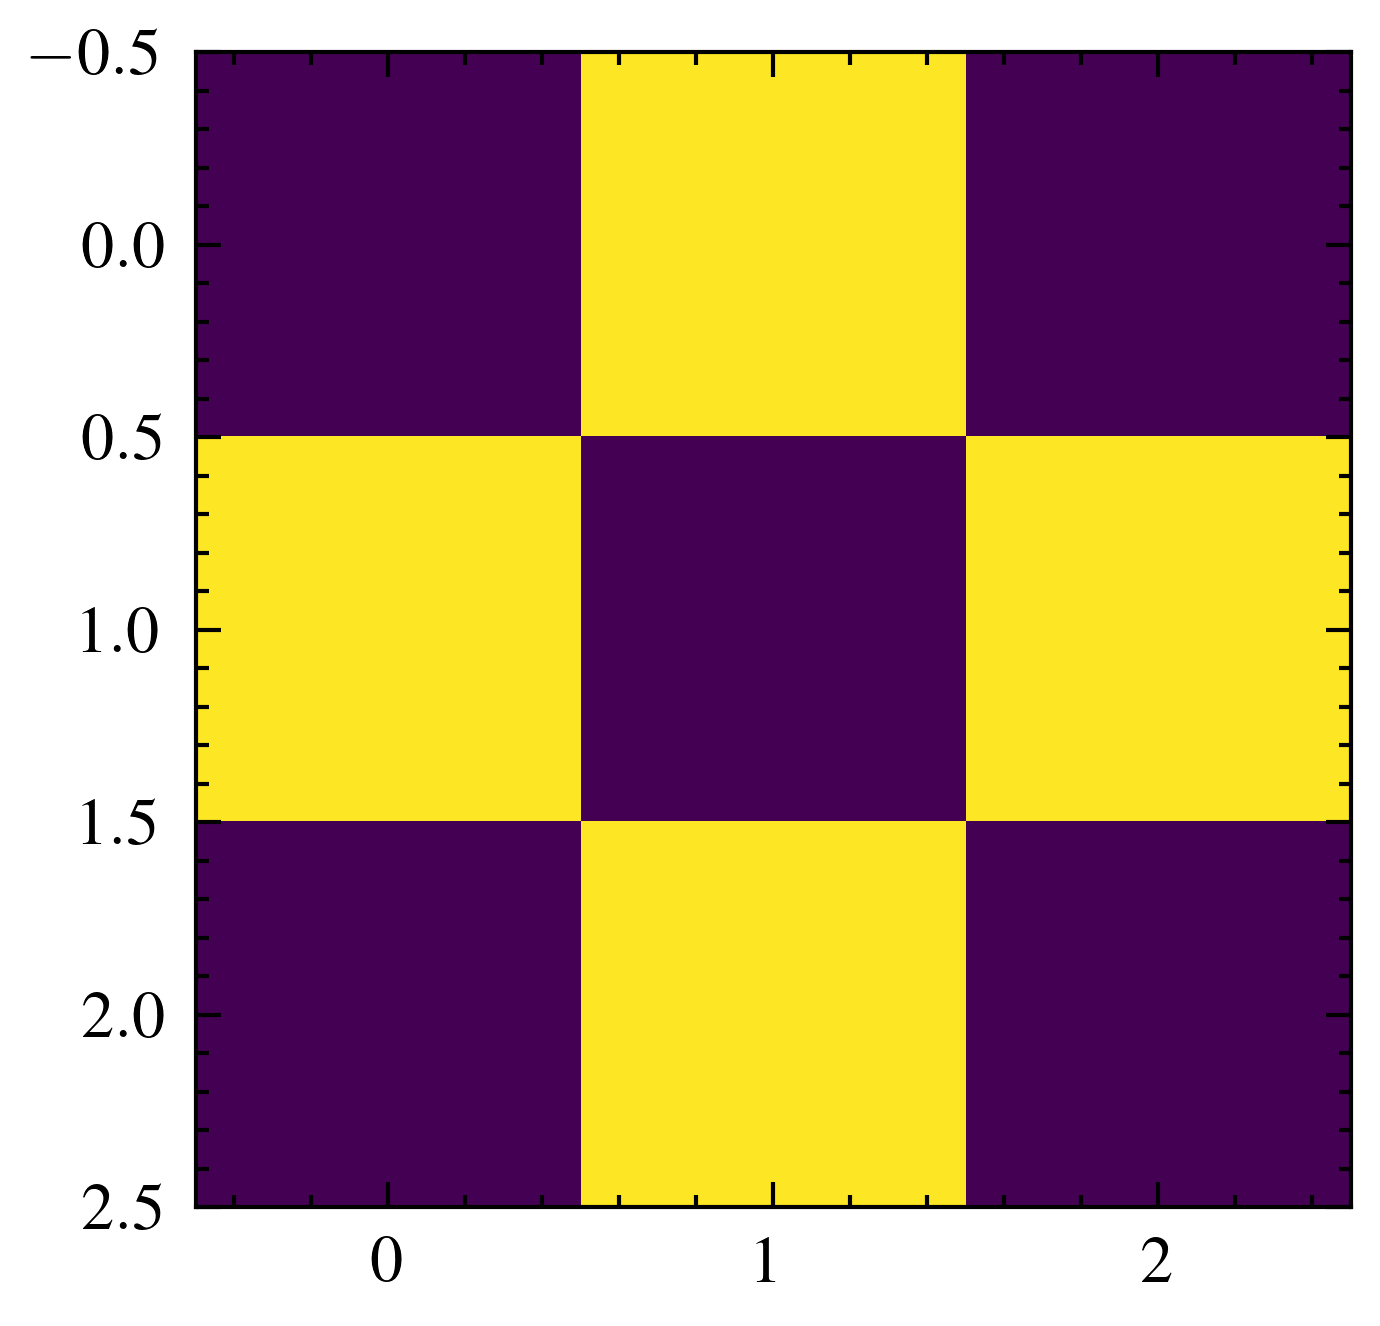

In [9]:
kern = ndimage.generate_binary_structure(2, 1)
kern[1][1]=False
plt.imshow(kern)

In [10]:
get_lattice_energy(lattice_Ne)

-172.0

In [11]:
@numba.njit("(f8[:,:], i8, f8, f8)", nogil=True)
def metropolis(spin_arr, times, T, energy):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    
    for t in range(0, times-1):
        x = np.random.randint(0, N)
        y = np.random.randint(0, N)
        spin_i = spin_arr[x, y] 
        spin_f = spin_i * -1
        E_i = -spin_i * (spin_arr[(x-1) % N, y] + spin_arr[(x+1) % N, y] + spin_arr[x, (y-1) % N] + spin_arr[x, (y+1) % N])
        E_f = -E_i
        dE = E_f - E_i
        if (dE > 0) * (np.random.random() < np.exp(-1/T * dE)):
            spin_arr[x, y] = spin_f
            energy += dE
        elif dE <= 0:
            spin_arr[x, y] = spin_f
            energy += dE 
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
            
    return net_spins, net_energy, spin_arr


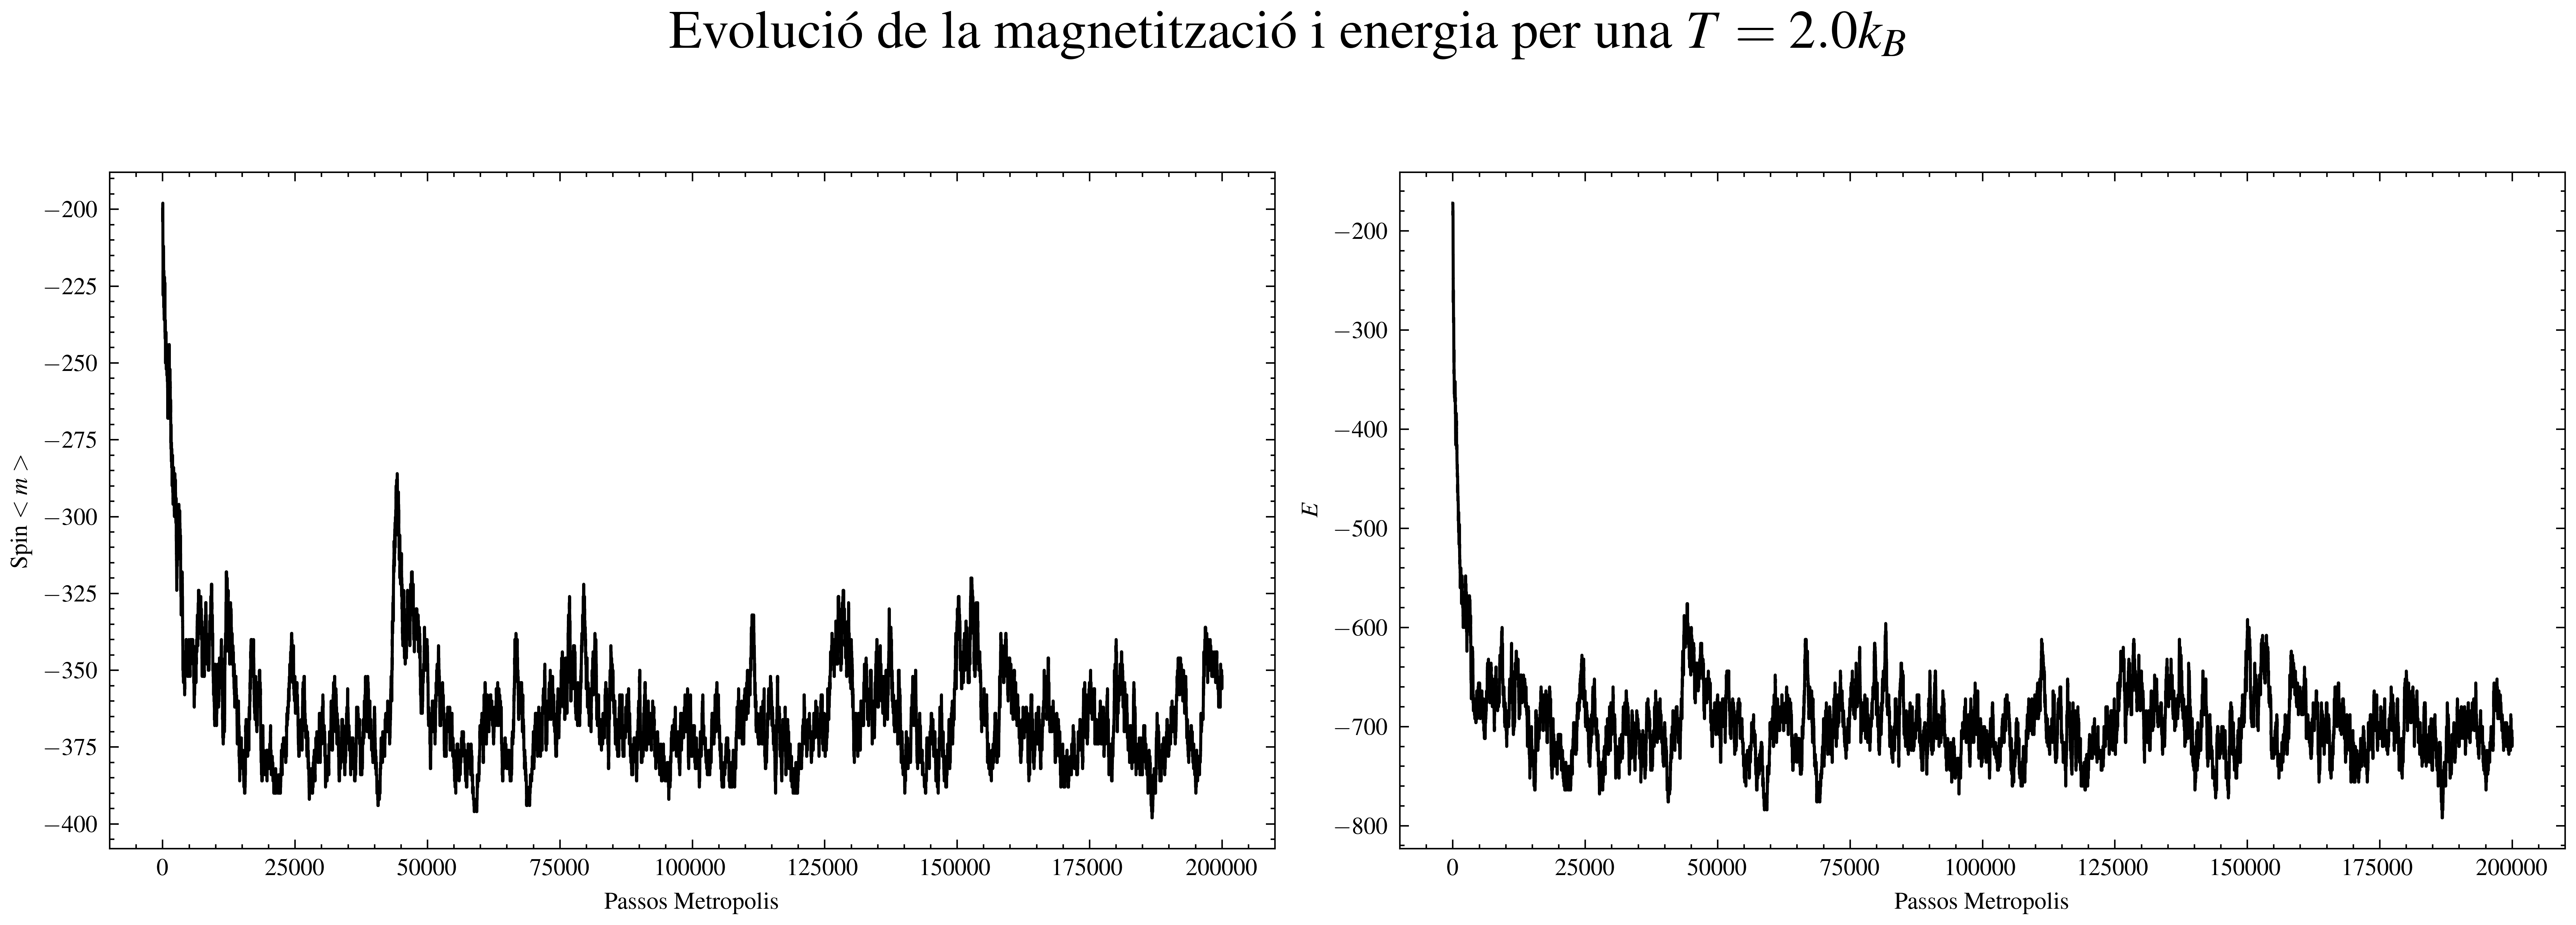

In [12]:
Spins,E,spins=metropolis(lattice_Ne,200000,2.0,get_lattice_energy(lattice_Ne))
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(np.arange(0,200000-1),Spins)
ax.set_xlabel('Passos Metropolis')
ax.set_ylabel(r'Spin $<m>$')
ax.grid(False)
ax = axes[1]
ax.plot(E)
ax.set_xlabel('Passos Metropolis')
ax.set_ylabel(r'$E$')
ax.grid(False)
fig.suptitle(r'Evolució de la magnetització i energia per una $T=2.0k_B$ ', y=1.07, size=18)
fig.tight_layout()
plt.show()

In [13]:
Ts = np.linspace(1.43, 5, 100)

In [14]:
Net_spins_Ne = np.zeros(len(Ts))
Net_spins_Po = np.zeros(len(Ts))
Net_energy_Ne = np.zeros(len(Ts))
Net_energy_Po = np.zeros(len(Ts))

prev_spins_Ne = None
prev_spins_Po = None

for i,T in enumerate(Ts):
    if prev_spins_Ne is None:
        Spins_Ne, E_Ne, spins_Ne = metropolis(lattice_Ne, 1000000, T, get_lattice_energy(lattice_Ne))
        Spins_Po, E_Po, spins_Po = metropolis(lattice_Po, 1000000, T, get_lattice_energy(lattice_Po))
    else:
        Spins_Ne, E_Ne, spins_Ne = metropolis(prev_spins_Ne, 200000, T, get_lattice_energy(prev_spins_Ne))
        Spins_Po, E_Po, spins_Po = metropolis(prev_spins_Po, 200000, T, get_lattice_energy(prev_spins_Po))

    Net_spins_Ne[i]=np.mean(Spins_Ne[-100000:])
    Net_energy_Ne[i]=np.mean(E_Ne[-100000:])
    Net_spins_Po[i]=np.mean(Spins_Po[-100000:])
    Net_energy_Po[i]=np.mean(E_Po[-100000:])
    
    prev_spins_Ne = spins_Ne
    prev_spins_Po = spins_Po

SystemError: CPUDispatcher(<function metropolis at 0x0000025683621040>) returned a result with an error set

In [15]:
def teorica(x):
    return 400*(1-(np.sinh(2/x))**(-4))**(1/8)
Tdens=np.linspace(np.min(Ts),np.max(Ts),10000)
Mdens=teorica(Tdens)

C:\Users\marcs\AppData\Local\Temp\ipykernel_18584\1049873147.py:2: RuntimeWarning: invalid value encountered in power
  return 400*(1-(np.sinh(2/x))**(-4))**(1/8)


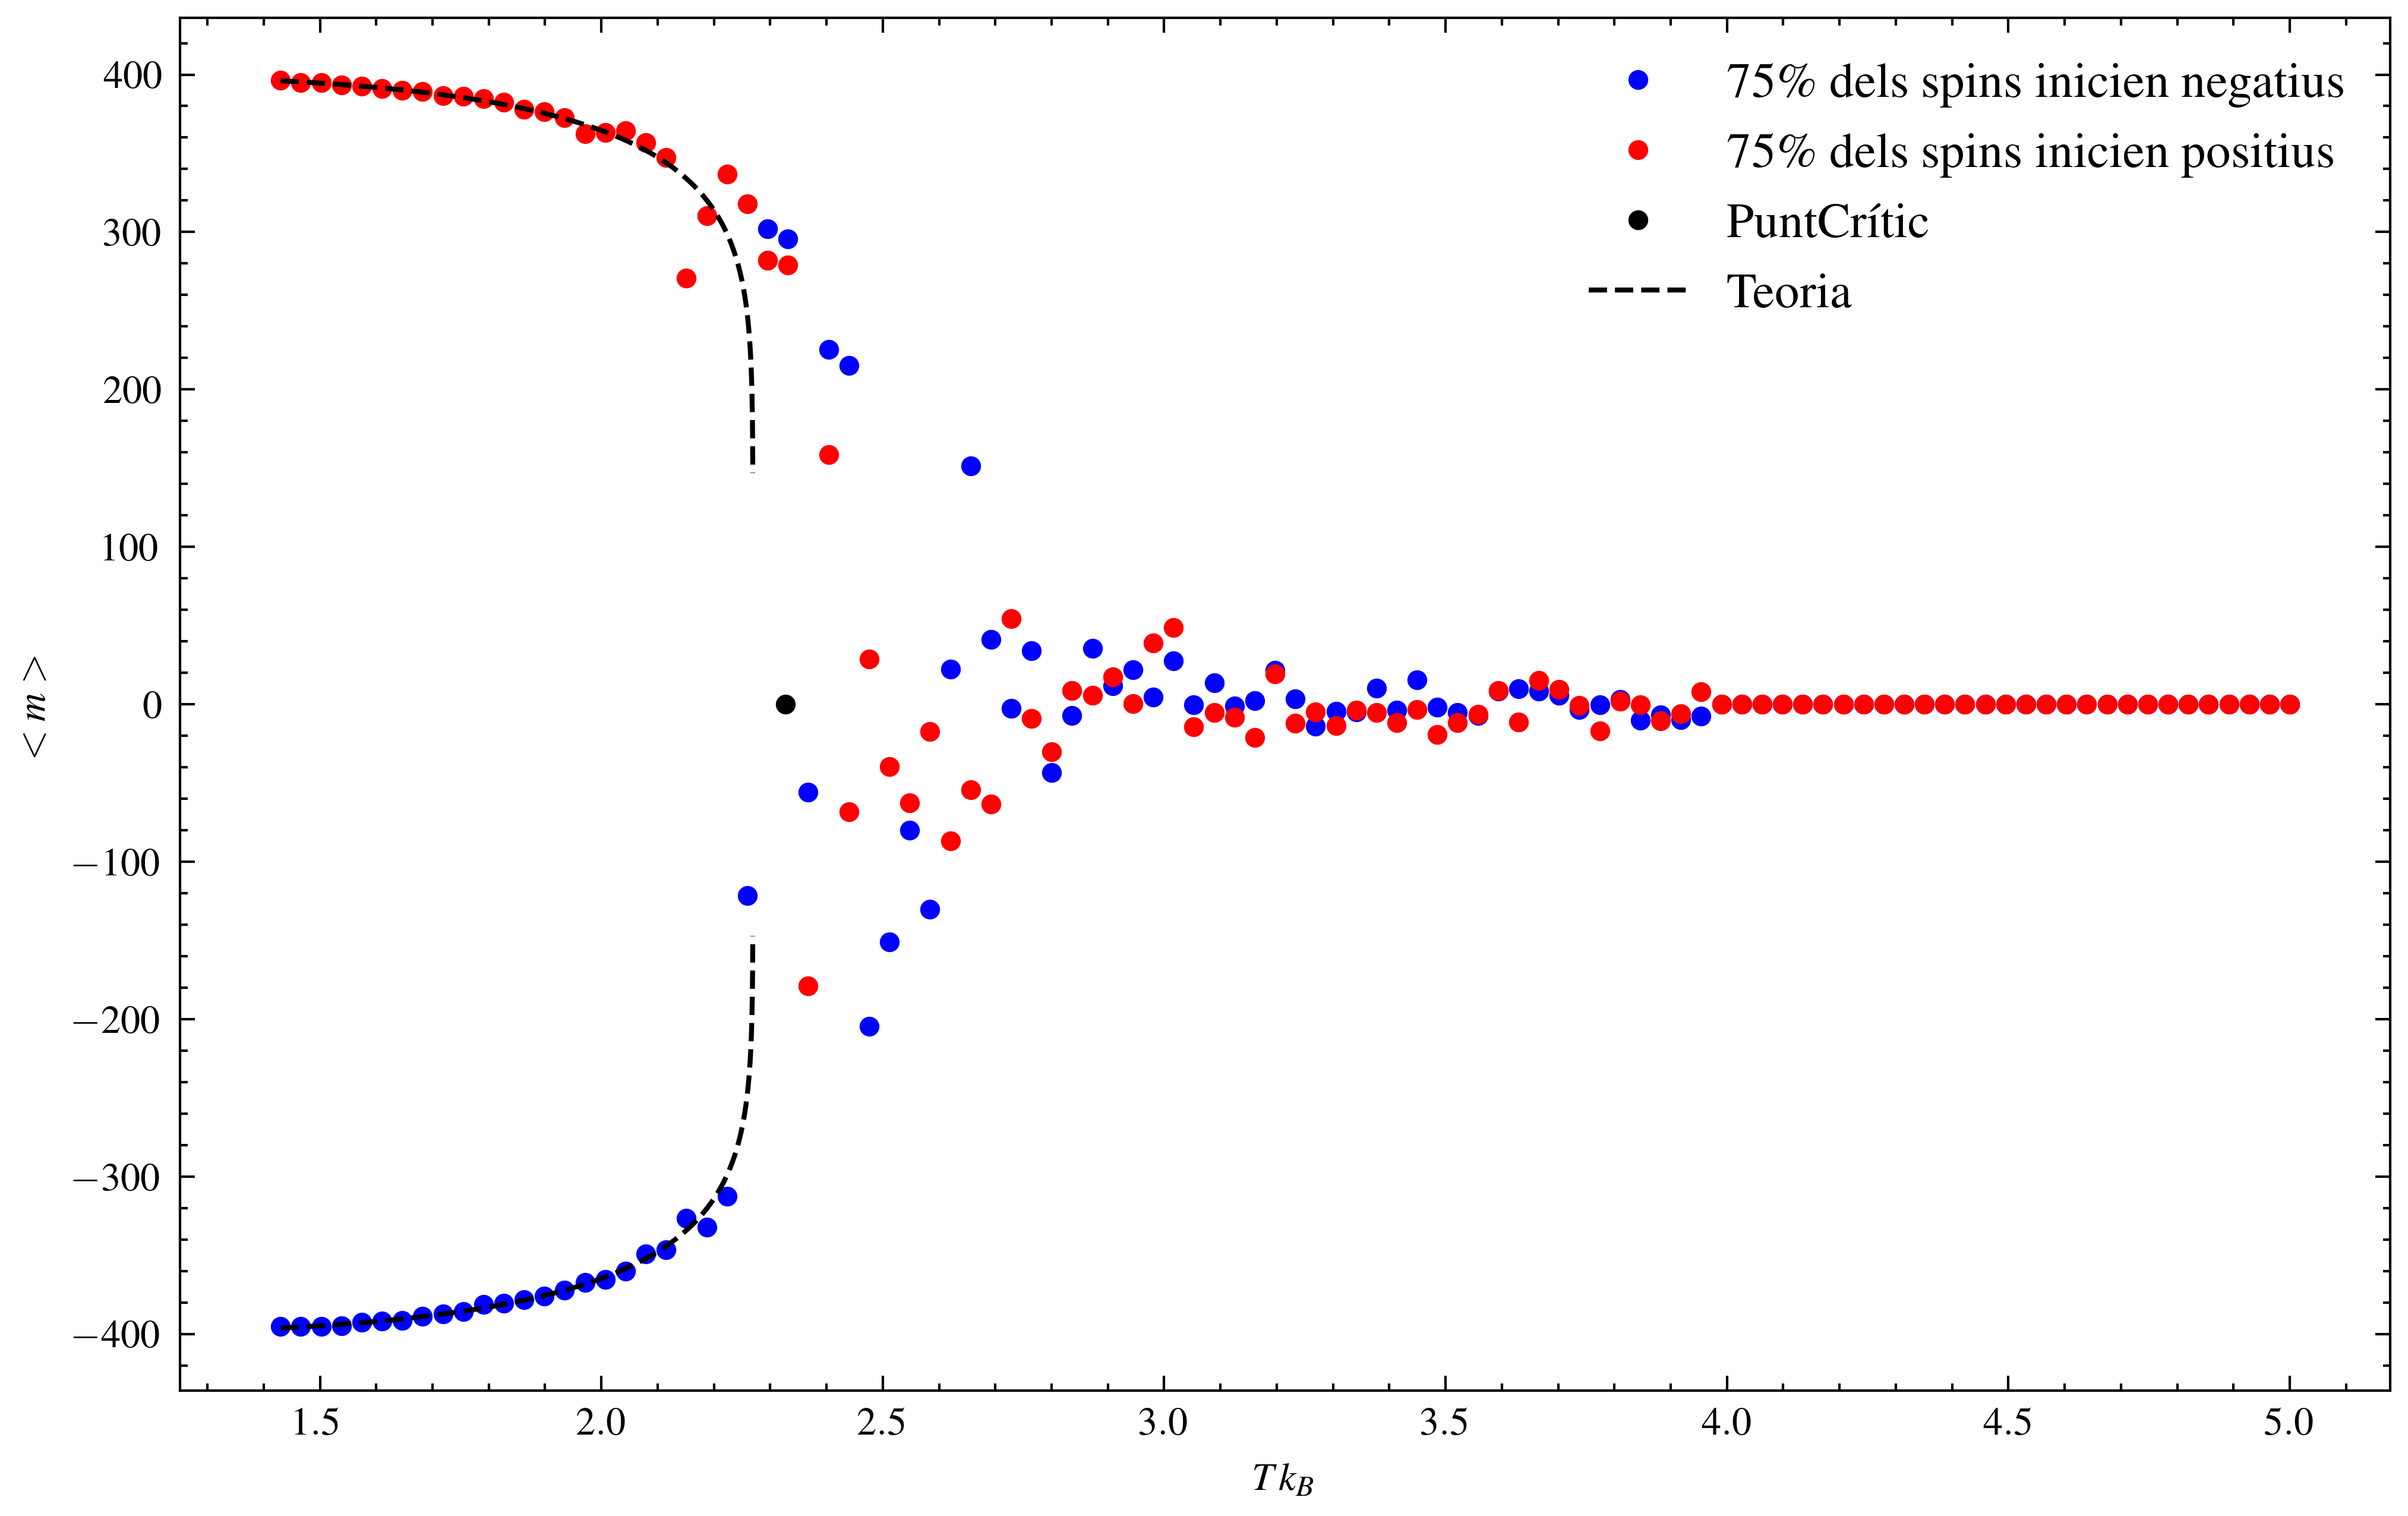

In [16]:
Tc=2.3275
plt.figure(figsize=(8,5))
plt.plot(Ts,Net_spins_Ne,'.',color='blue',label='75\% dels spins inicien negatius')
plt.plot(Ts,Net_spins_Po,'.',color='red',label='75\% dels spins inicien positius')
plt.plot([Tc],[0],'.',color='black',label='PuntCrític')
plt.plot(Tdens,Mdens,'--',color='black',label='Teoria')
plt.plot(Tdens,-Mdens,'--',color='black')
plt.grid(False)
plt.xlabel(r'$T k_B$')
plt.ylabel(r'$<m>$')
plt.legend(fontsize=10)
plt.show()

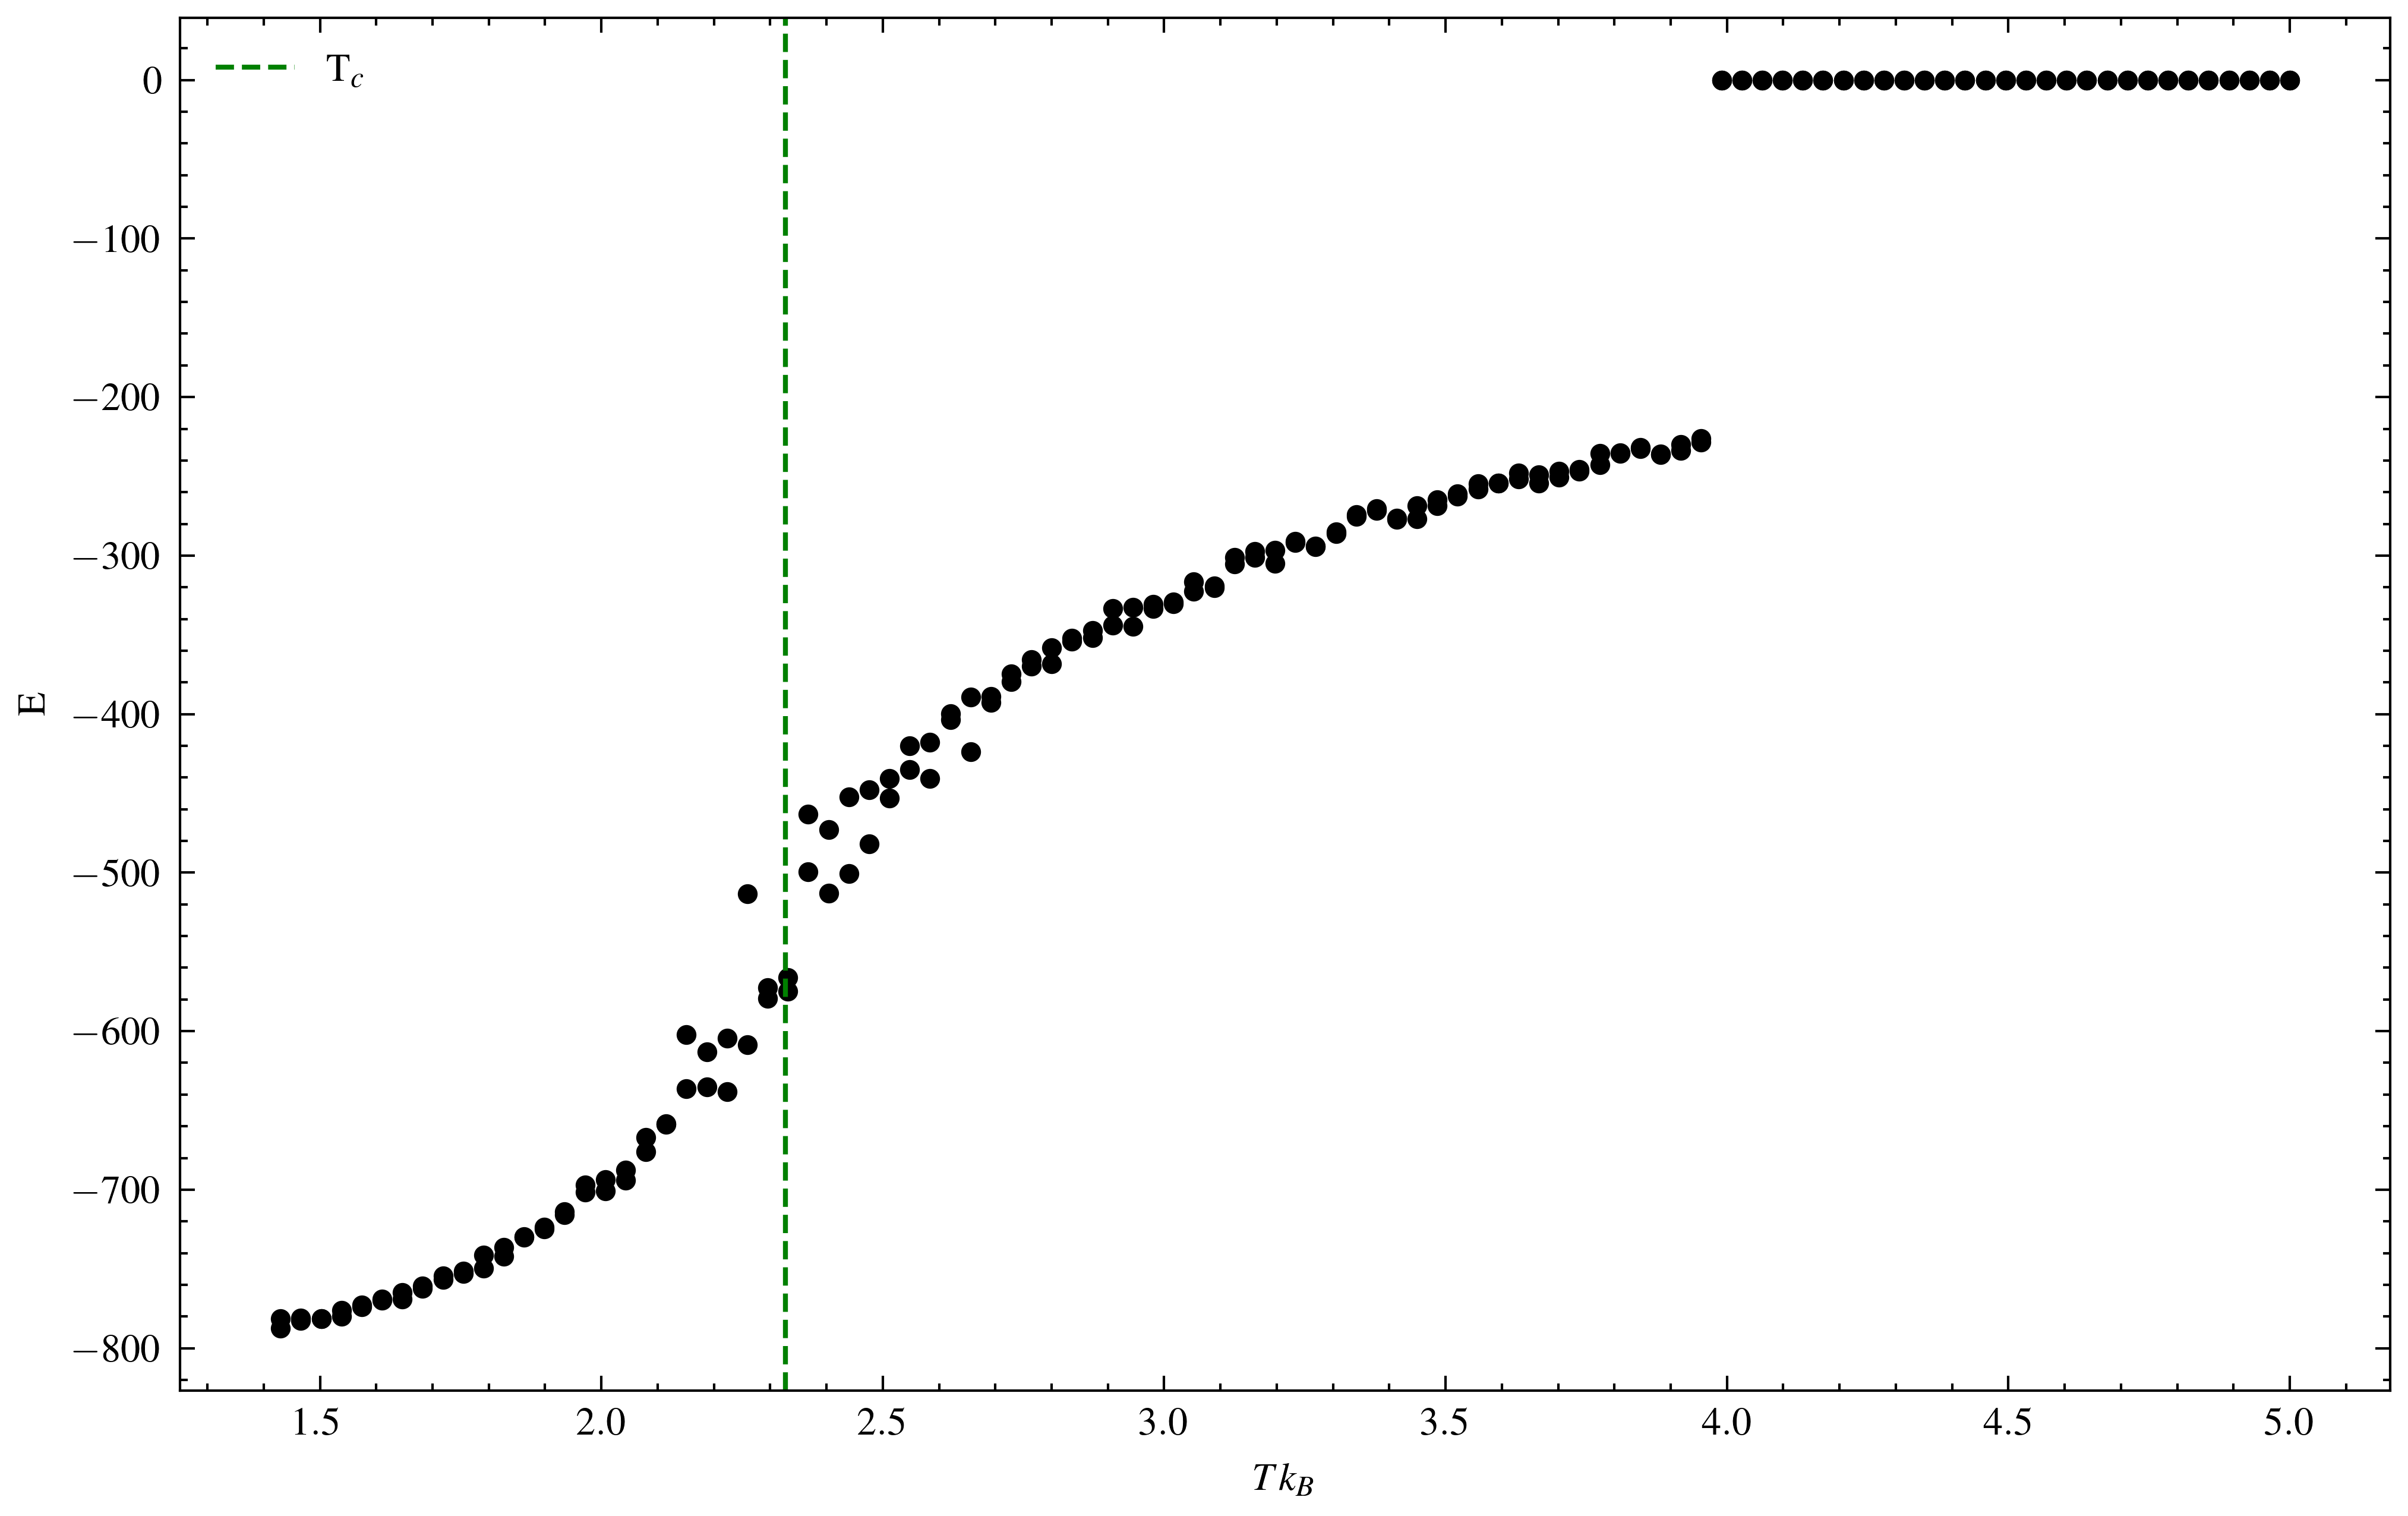

In [17]:
plt.figure(figsize=(8,5))
plt.plot(Ts,Net_energy_Ne,'.',color='black')
plt.plot(Ts,Net_energy_Po,'.',color='black')
plt.axvline(Tc,ls='--',color='green',label=r'T$_c$')
plt.legend()
plt.grid(False)
plt.xlabel(r'$T k_B$')
plt.ylabel(r'E')
plt.show()

In [18]:
Tc=2.3275
TsC = np.linspace(Tc-0.4, Tc, 300)

In [19]:
Net_spins = np.zeros(len(TsC))
Net_energy = np.zeros(len(TsC))
Spins_fluct = np.zeros(len(TsC))
E_fluct = np.zeros(len(TsC))
init_random=np.random.random((N,N))
lattice=np.ones((N,N))

In [20]:
for i in range(len(TsC)):
    Spins, E, spins = metropolis(lattice, 5000000, TsC[i], get_lattice_energy(lattice))
    Net_spins[i]=np.mean(Spins[-500000:])
    Net_energy[i]=np.mean(E[-500000:])
    Spins_fluct[i]=np.std(Spins[-1000000:])
    E_fluct[i]=np.std(E[-1000000:])

SystemError: CPUDispatcher(<function metropolis at 0x0000025683621040>) returned a result with an error set

In [ ]:
Net_spins2=Net_spins[Net_spins>=0]
TsC2=TsC[Net_spins>=0]
DeltaT=np.abs(Tc-TsC2)
def m(dT,k,alpha):
    return k*dT**alpha 
parameters,cov=cf(m,DeltaT,Net_spins2/N**2)
print(parameters)

[1.14106679 0.19615774]


Text(0, 0.5, '$<m>/N^2$')

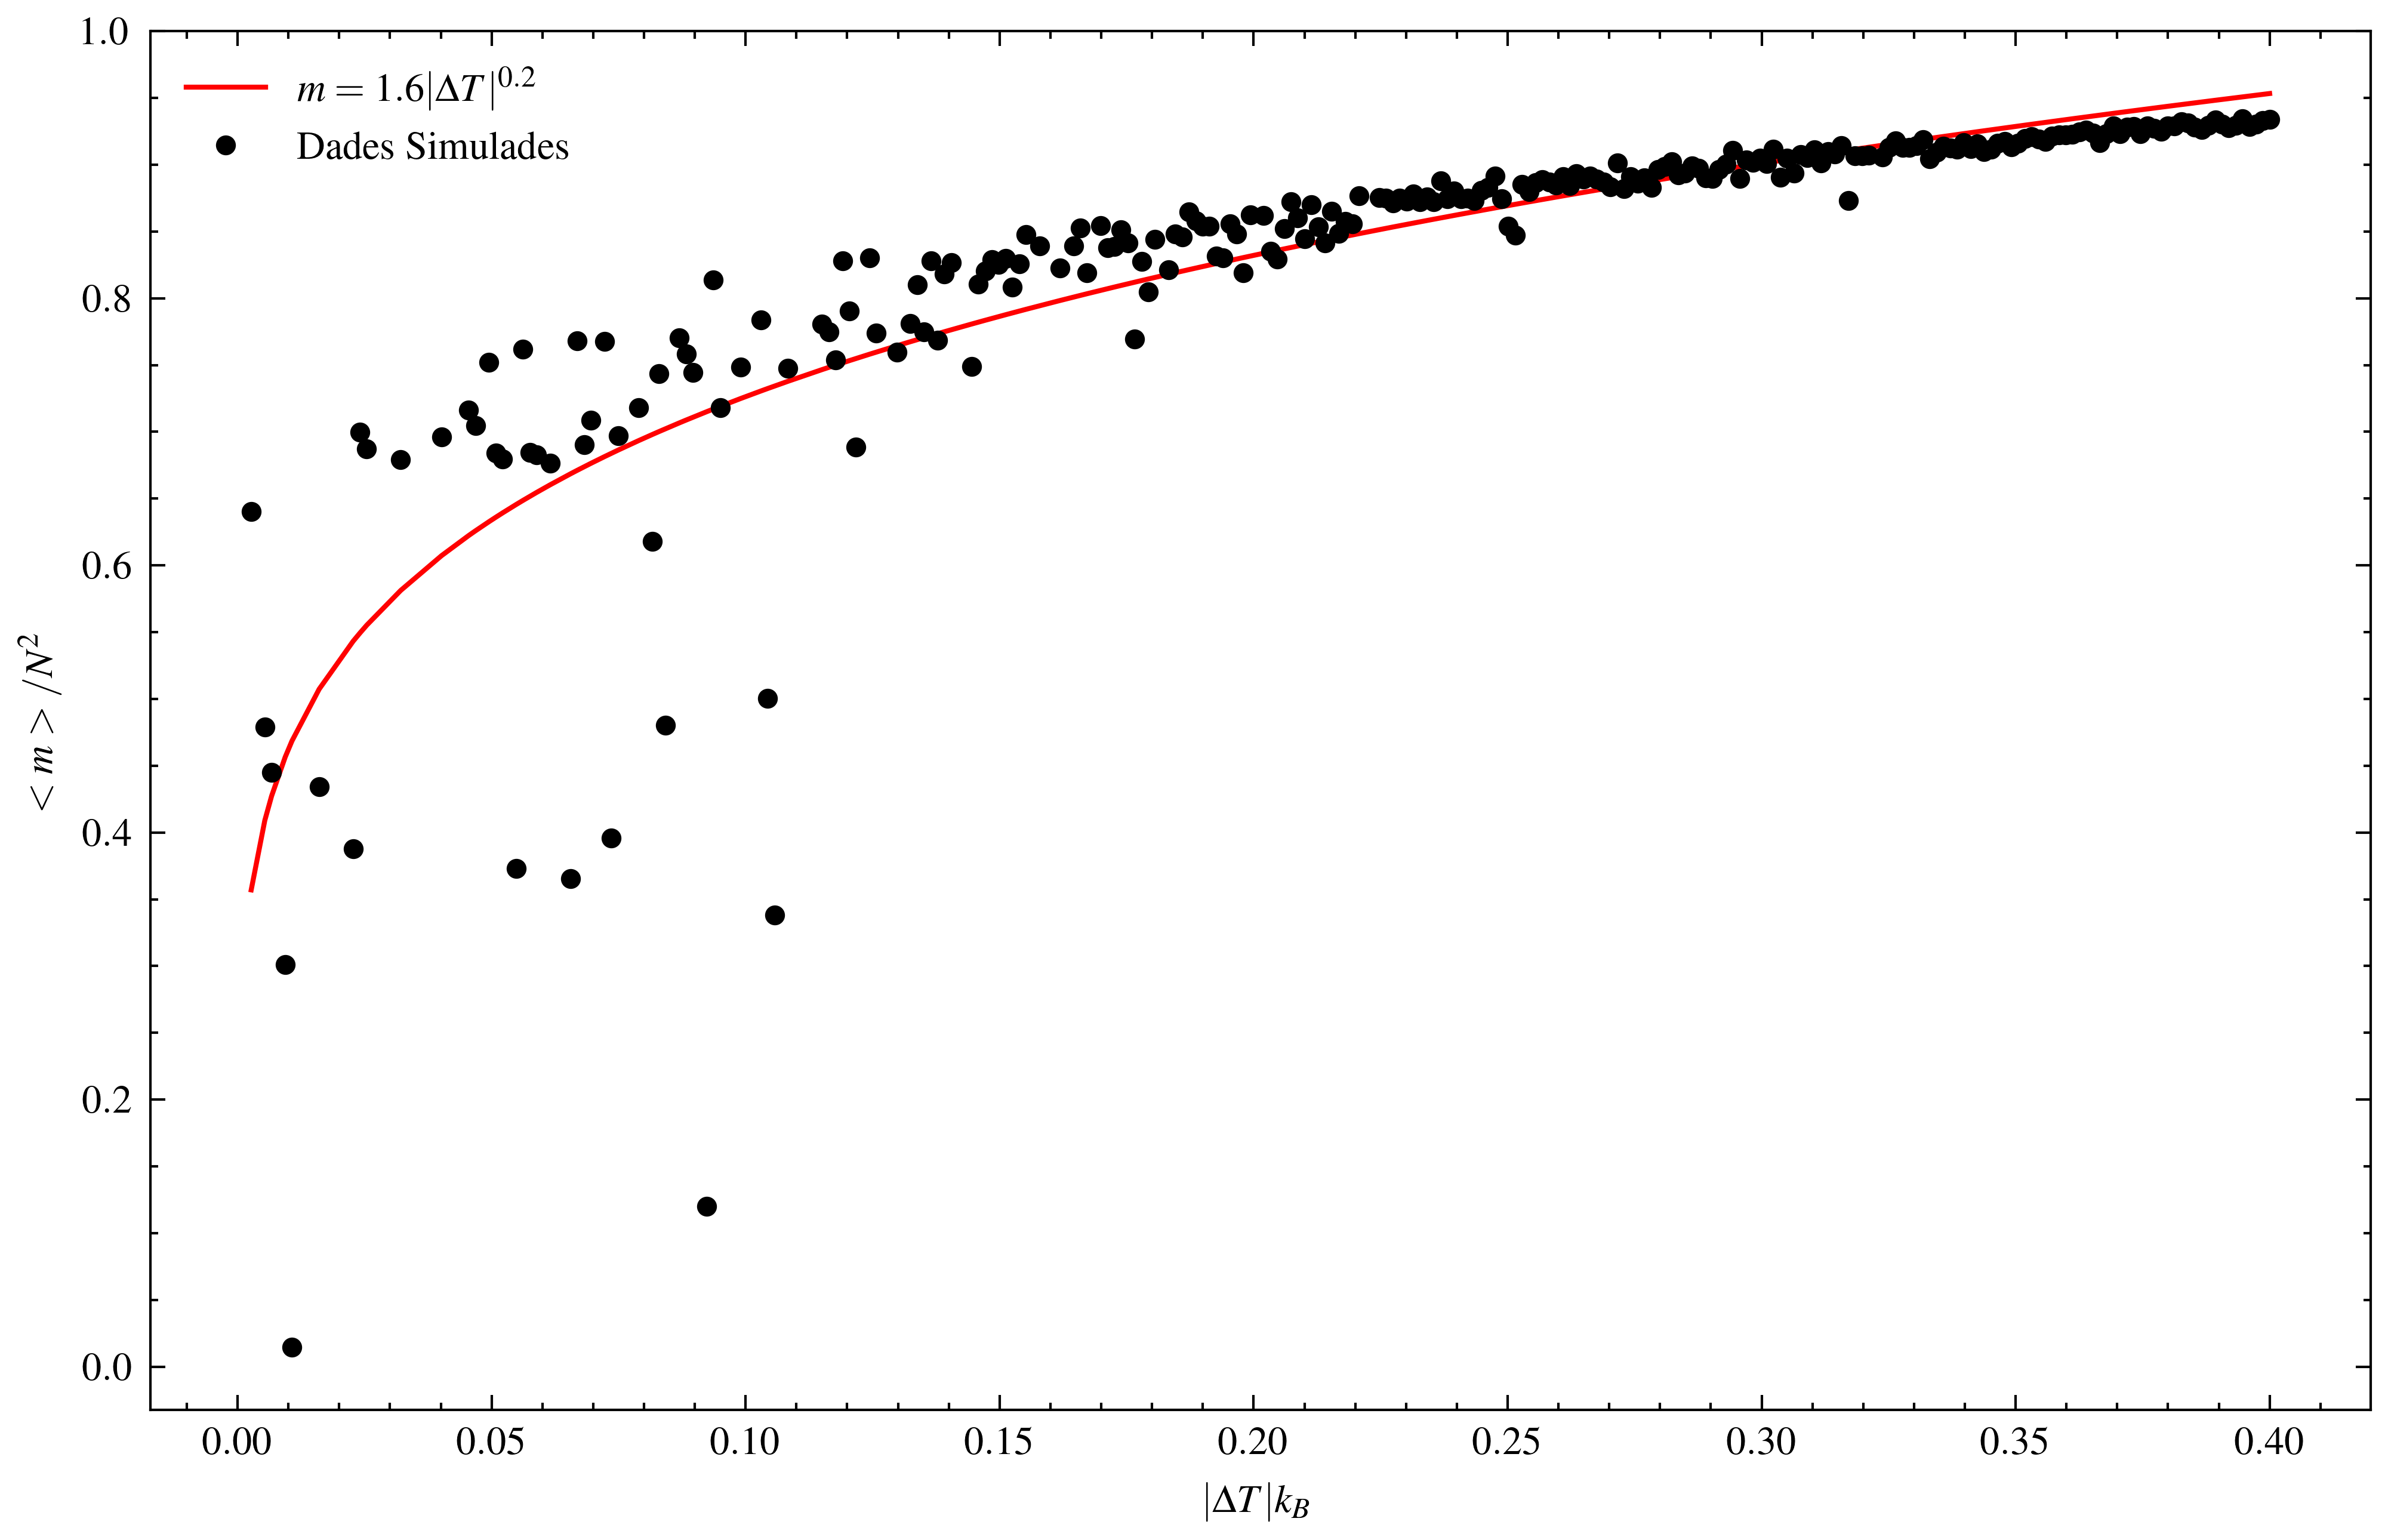

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(DeltaT,m(DeltaT,*parameters),color='red',label=r'$m=1.6|\Delta T|^{0.2}$')
plt.plot(DeltaT,Net_spins2/N**2,'.',color='black',label='Dades Simulades')
plt.legend()
plt.grid(False)
plt.xlabel(r'$|\Delta T| k_B$')
plt.ylabel(r'$<m>/N^2$')


Text(0, 0.5, '$\\frac{\\chi_T}{N^2 T}$')

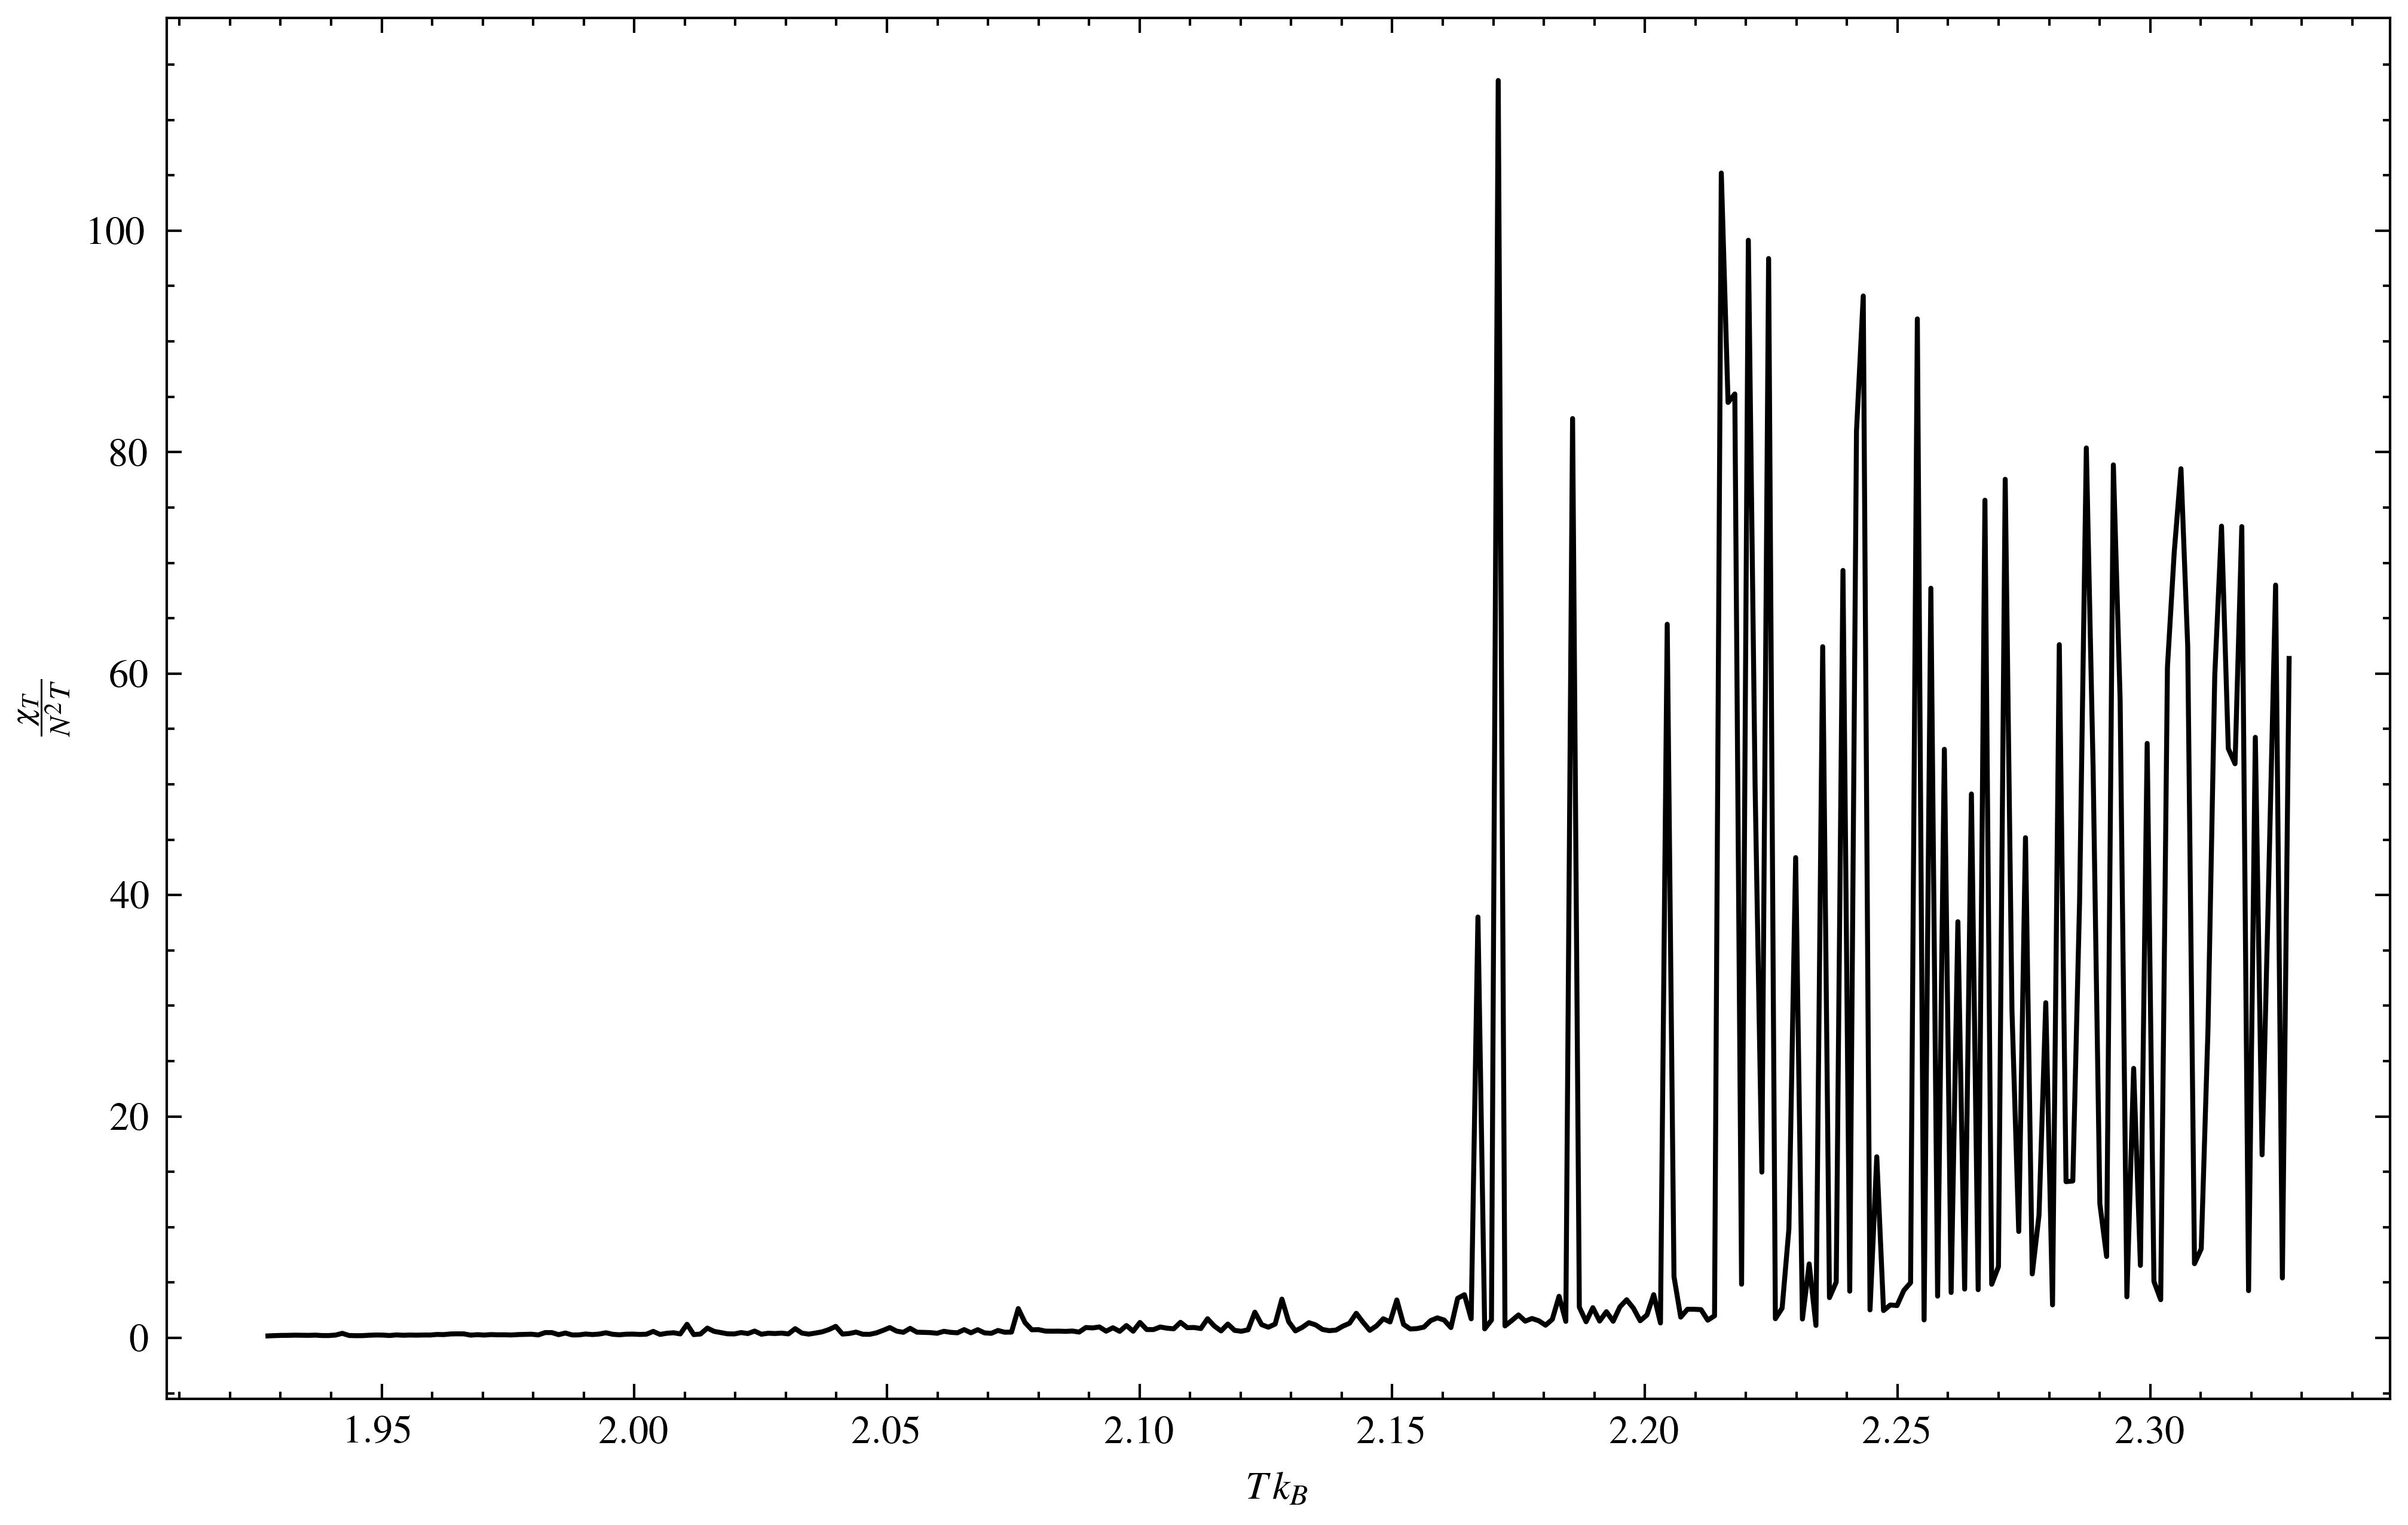

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(TsC,Spins_fluct**2/(N**2*TsC))
plt.grid(False)
plt.xlabel(r'$T k_B$')
plt.ylabel(r'$\frac{\chi_T}{N^2 T}$')

Text(0, 0.5, '$\\frac{C_V}{T^2 N^2}$')

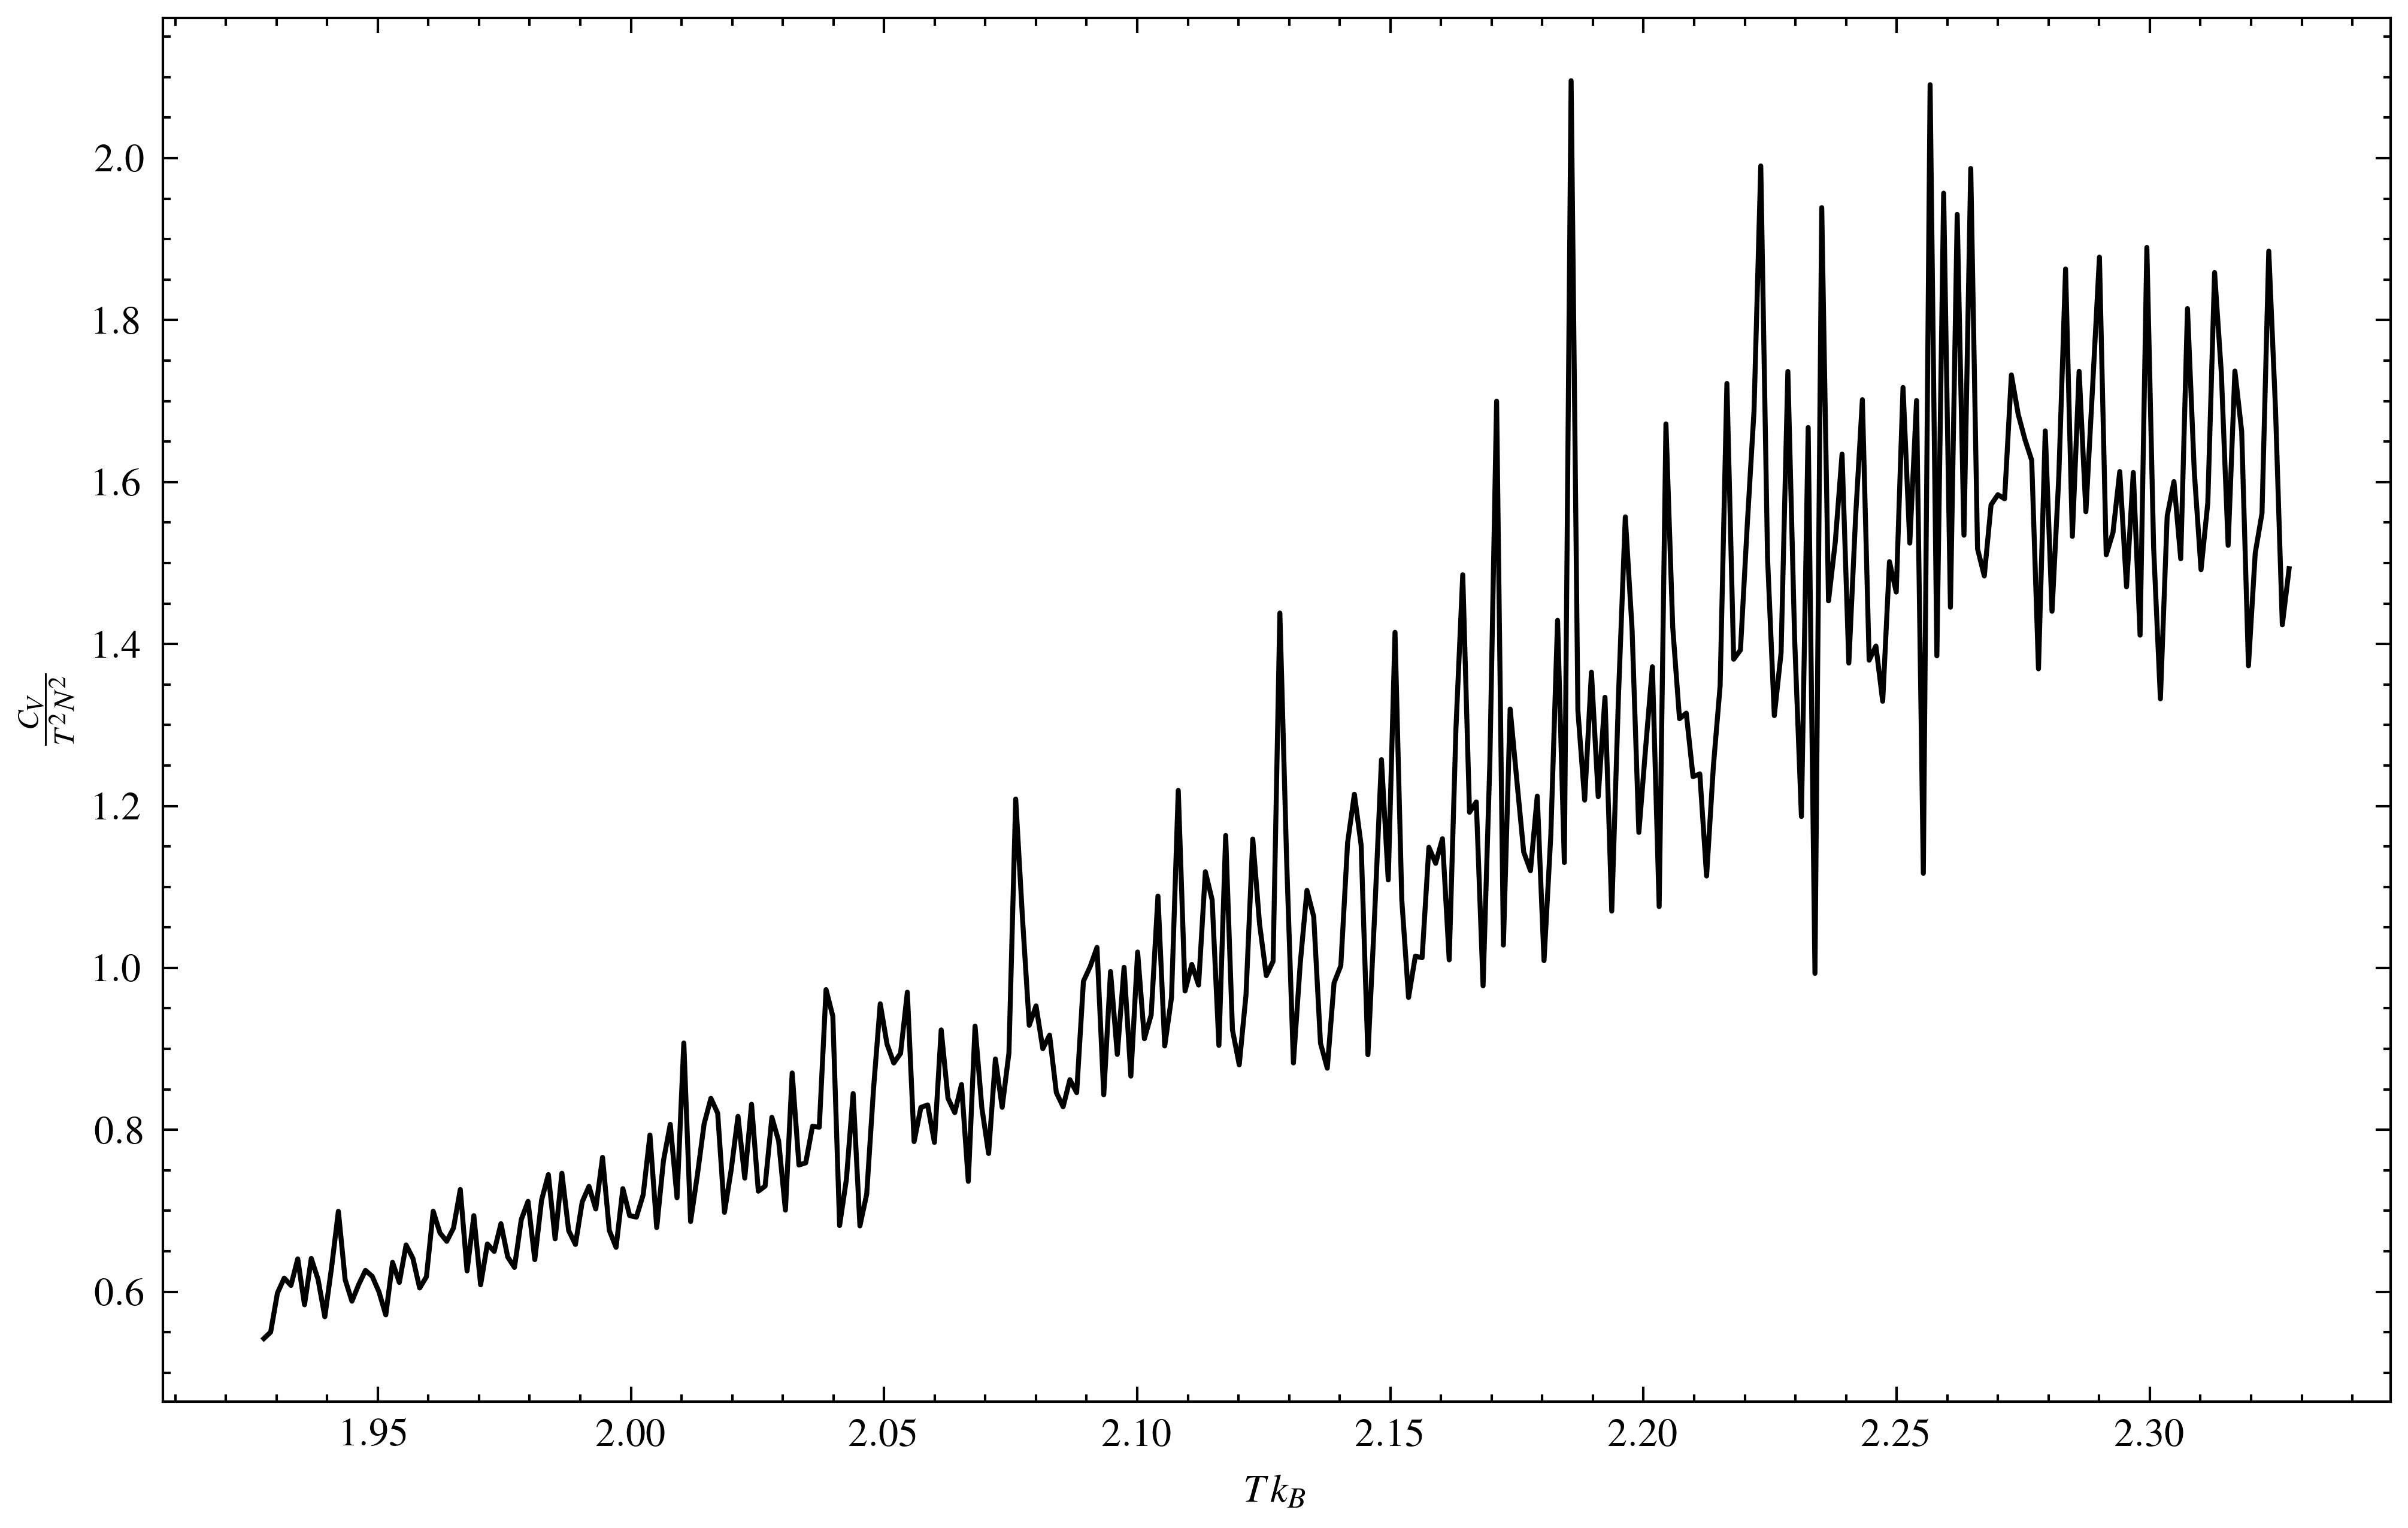

In [ ]:

plt.figure(figsize=(8,5))
plt.plot(TsC,E_fluct**2/N**2/TsC**2)
plt.grid(False)
plt.xlabel(r'$T k_B$')
plt.ylabel(r'$\frac{C_V}{T^2 N^2}$')

In [21]:
@numba.njit("(f8[:,:], i8, f8, f8)", nogil=True)
def metropolis_MB(spin_arr, times, T, energy):
    spin_arr = spin_arr.copy()
    Bins=np.array([-4,-2,0,2,4])
    Freq=np.array([0,0,0,0,0])
    for t in range(0, times-1):
        x = np.random.randint(0, N)
        y = np.random.randint(0, N)
        spin_i = spin_arr[x, y] 
        spin_f = spin_i * -1
        E_i = -spin_i * (spin_arr[(x-1) % N, y] + spin_arr[(x+1) % N, y] + spin_arr[x, (y-1) % N] + spin_arr[x, (y+1) % N])
        E_f = -E_i
        dE = E_f - E_i
        if (dE > 0) * (np.random.random() < np.exp(-1/T * dE)):
            spin_arr[x, y] = spin_f
            energy += dE
        elif dE <= 0:
            spin_arr[x, y] = spin_f
            energy += dE

        if t >= 1E6 and t%1E5==0: #Definim que per aquestes iteracionns ja estarem a l'equilibri
            for n in range(N):
                for m in range(N):
                    E_spin=-spin_arr[n,m] * (spin_arr[(n-1) % N, m] + spin_arr[(n+1) % N, m] + spin_arr[n, (m-1) % N] + spin_arr[n, (m+1) % N])
                    Freq[E_spin==Bins]+=1
    return Freq




In [22]:
T_MB=4.5
Bins=np.array([-4,-2,0,2,4]) 
Freq=metropolis_MB(lattice_Po,1E7,T_MB,get_lattice_energy(lattice_Po))


In [29]:
Bins=np.array([-4,-2,0,2,4]) 
g=np.array([2,8,12,8,2])
Z=0
for i in range(5):
    Z+=g[i]*np.exp((-1/T_MB*Bins[i]))
print(Z)
P=[]
for i in range(5):
    P.append(g[i]*np.exp(-1/T_MB*Bins[i])/Z)
Inc_P=[]
for i in range(5):
    Inc_P.append(g[i]*np.exp(-1/T_MB*Bins[i])*(0.1/(T_MB**2)))

35.293506577882674


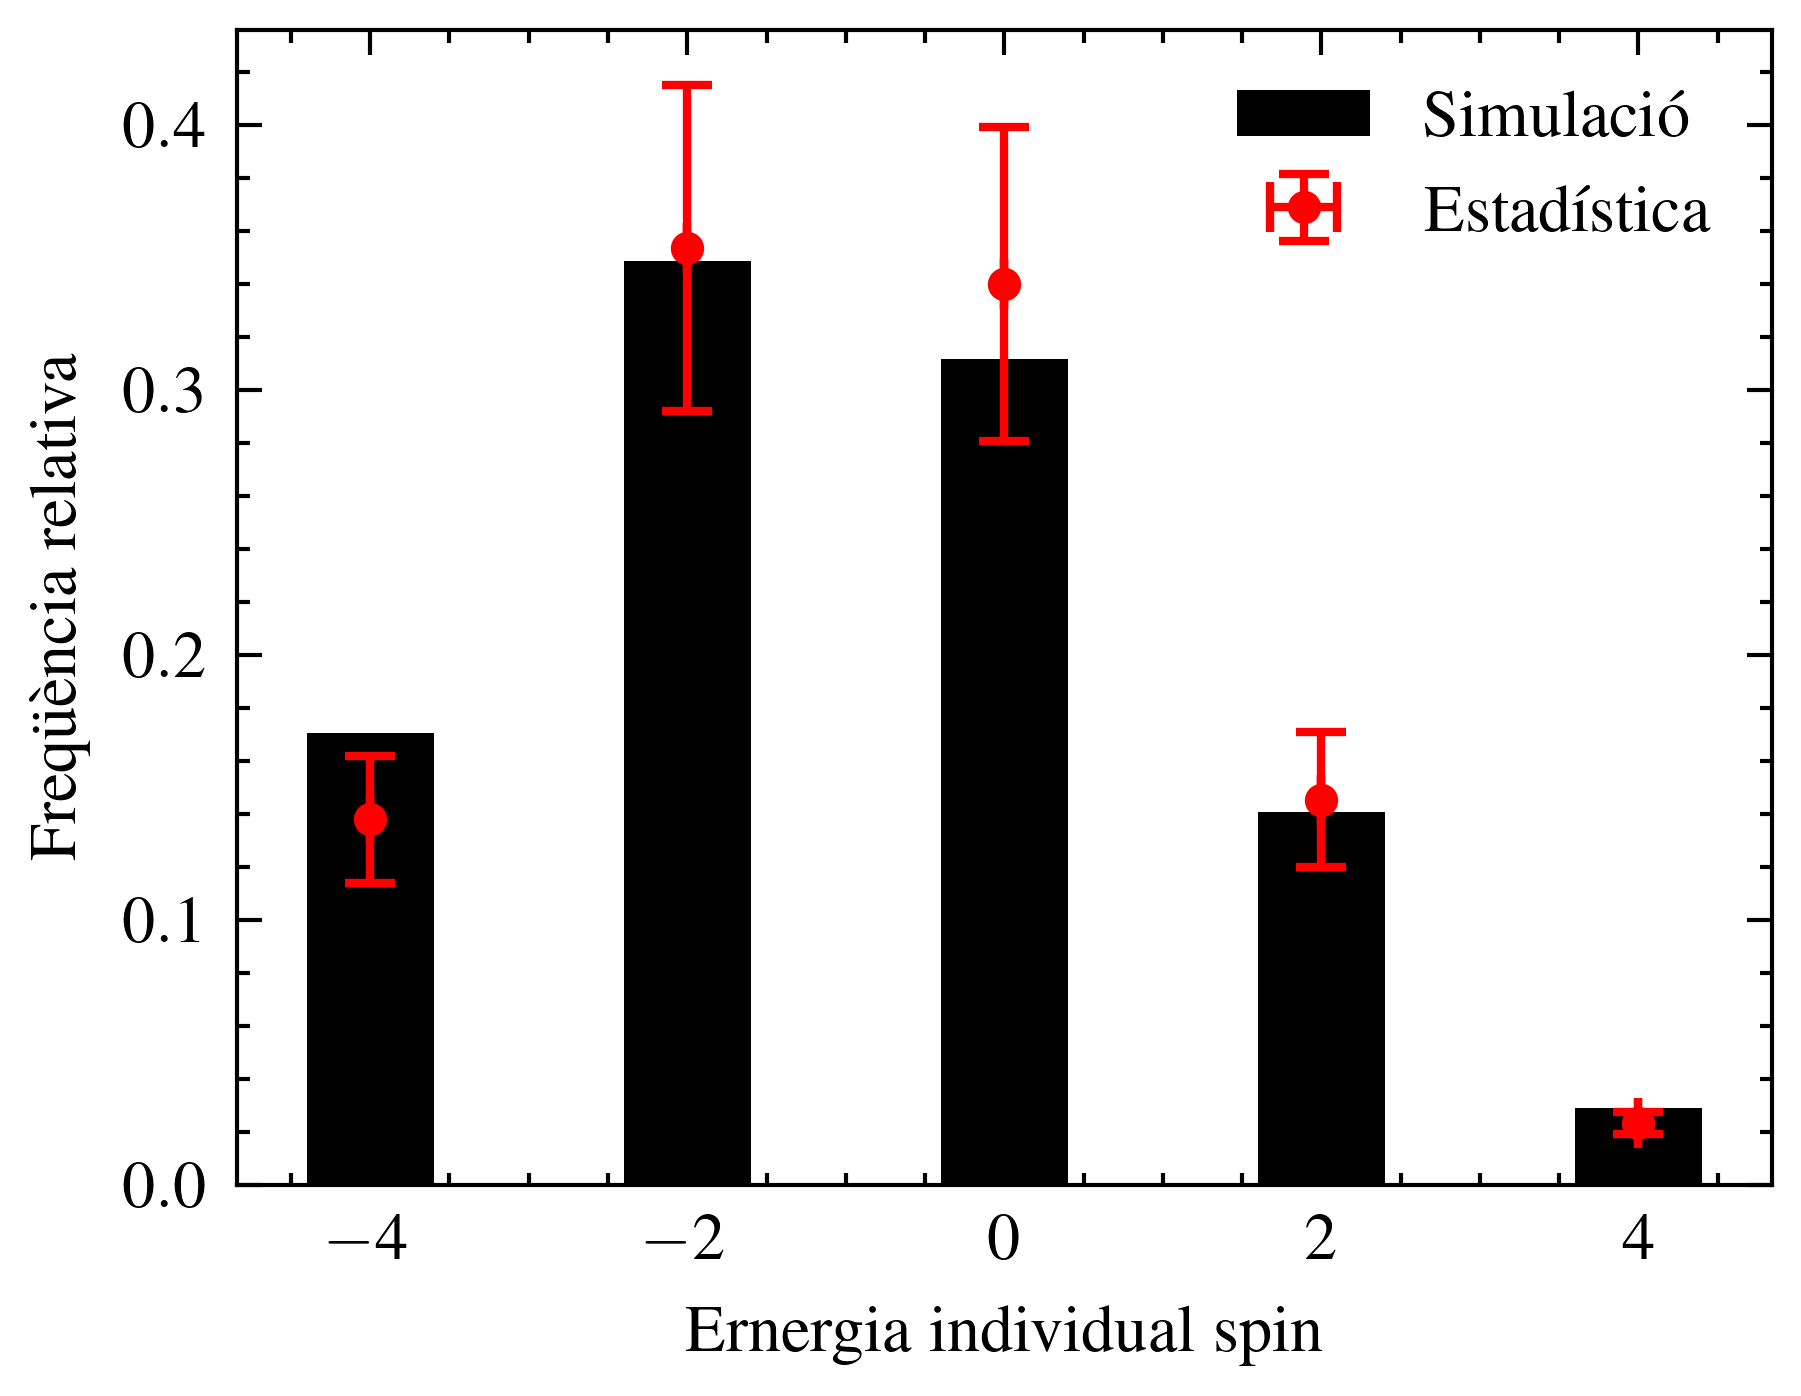

In [37]:
plt.bar(Bins,Freq/Freq.sum(),label='Simulació')
plt.errorbar(Bins,P,Inc_P,0,'.',capsize=3,color='red',label='Estadística')
plt.ylabel('Freqüència relativa')
plt.xlabel('Ernergia individual spin')
plt.legend()
